# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *L*

**Names:**

* *Imane Benkamoun*
* *Gabriel Yehouda Gozlan*
* *Mathis Le Dortz*
* *Hervé Sérandour*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.1 Exploration of real networks

#### Exercise 2.1

Question 1

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

from random import randint
from IPython.display import display
from IPython.display import display
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

In [2]:
path = "../data/network1.csv"
nameOfColumns = ["fromNodeId", "toNodeId"]


network1 = pd.read_csv(path, names=nameOfColumns, skiprows=2)
network1.head()

,fromNodeId,toNodeId
0,0,11932
1,1,5128
2,2,7008
3,3,10476
4,4,9671


In [3]:
"""
After loading the csv into a dataframe, 
we create the structure of the undirected graph
"""


graphNetwork1 = nx.Graph()
graphNetwork1.add_nodes_from(network1["fromNodeId"])
graphNetwork1.add_nodes_from(network1["toNodeId"])

edges = [(i, j) for i,j in zip(network1["fromNodeId"], network1["toNodeId"])]
graphNetwork1.add_edges_from(edges)


In [4]:
def visualize_graph(network, step_size = 500, limit_nb_nodes = 3001):
    
    """
    This function allows the visualization of the network every step_size nodes up to 3000 nodes.
    """
    def on_button_click(button):
        for i in range(step_size, limit_nb_nodes, step_size):
            min_node = min(network.nodes())
            nodes_to_display = range(min_node, i)
            subgraph = network.subgraph(nodes_to_display)
            plt.figure(figsize=(10, 10))
            nx.draw(subgraph, with_labels=False, node_size=1)
            plt.title(f"Visualization of the Network graph with {i} nodes")
            plt.show()

    # Creation of the button
    button = widgets.Button(description=f"Network graph every {step_size} node")
    button_width = "500px"
    button.layout.width = button_width
    display(button)

    # Bind visualization function to button click
    button.on_click(lambda _: on_button_click(button))



Button(description='Network graph every 500 node', layout=Layout(width='500px'), style=ButtonStyle())

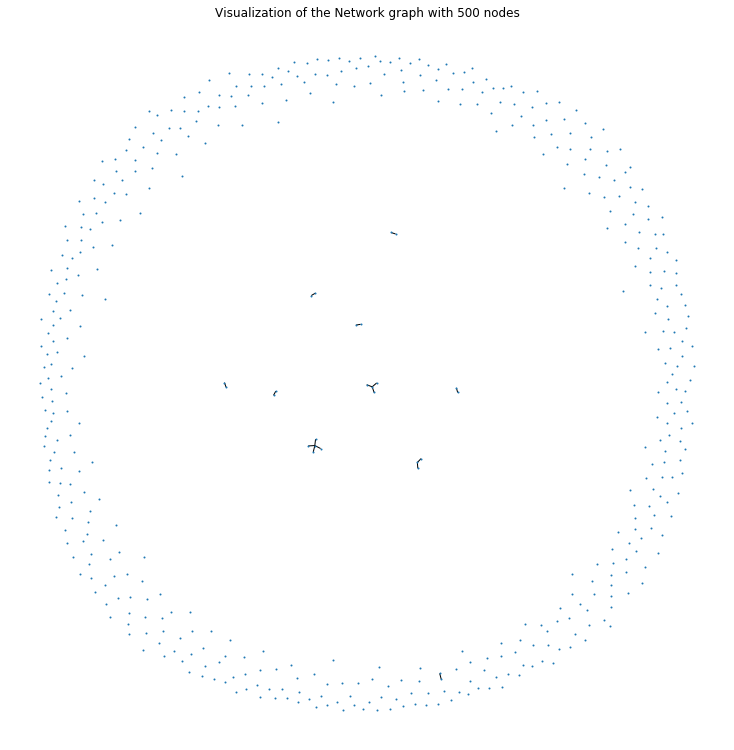

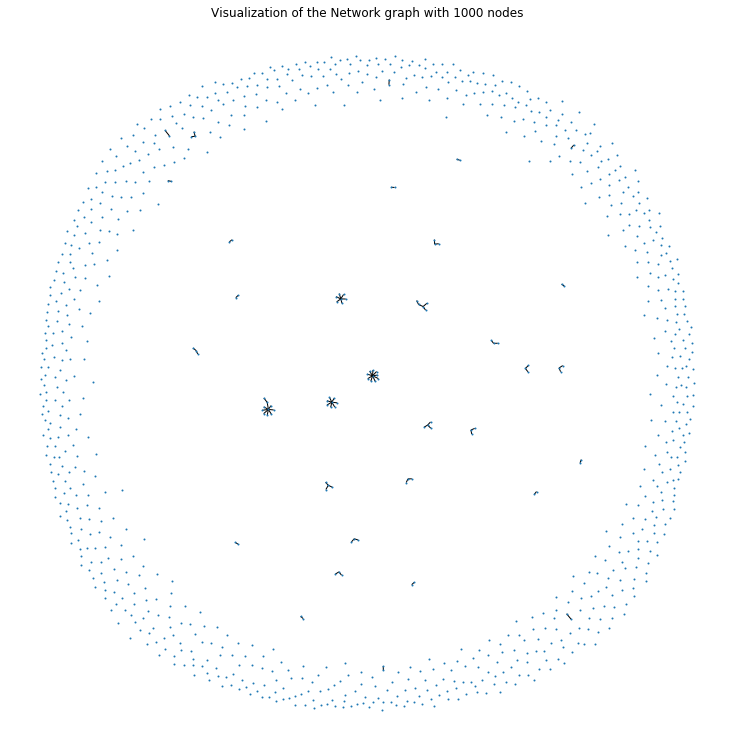

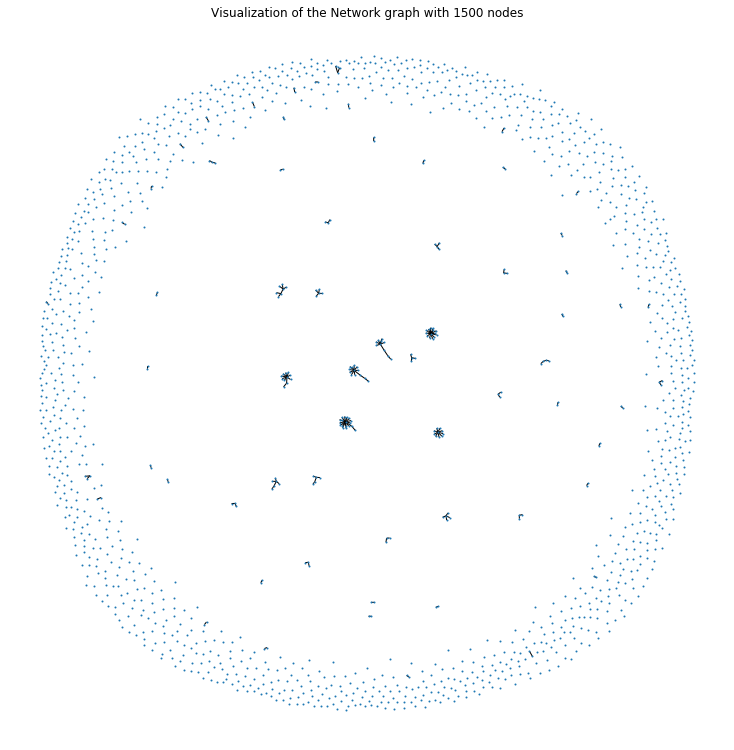

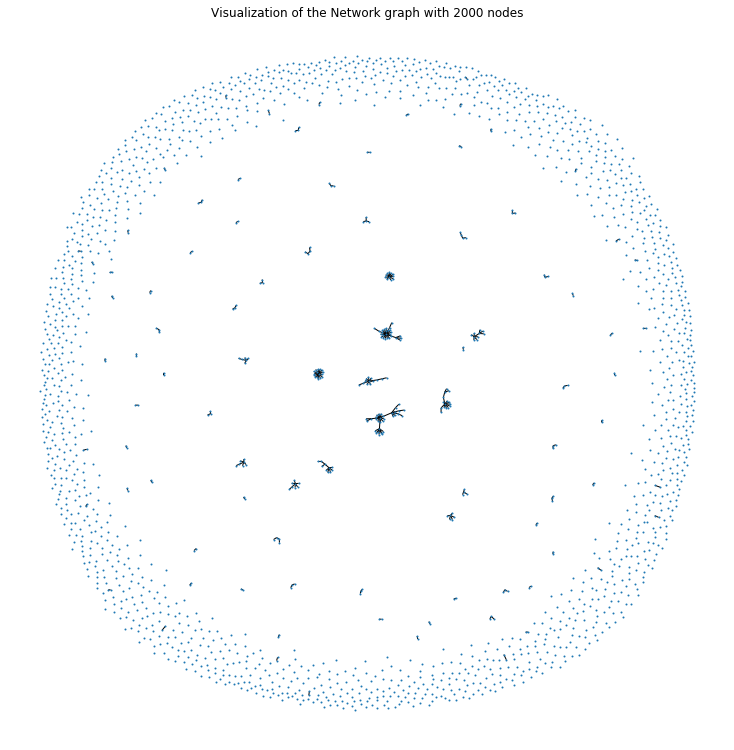

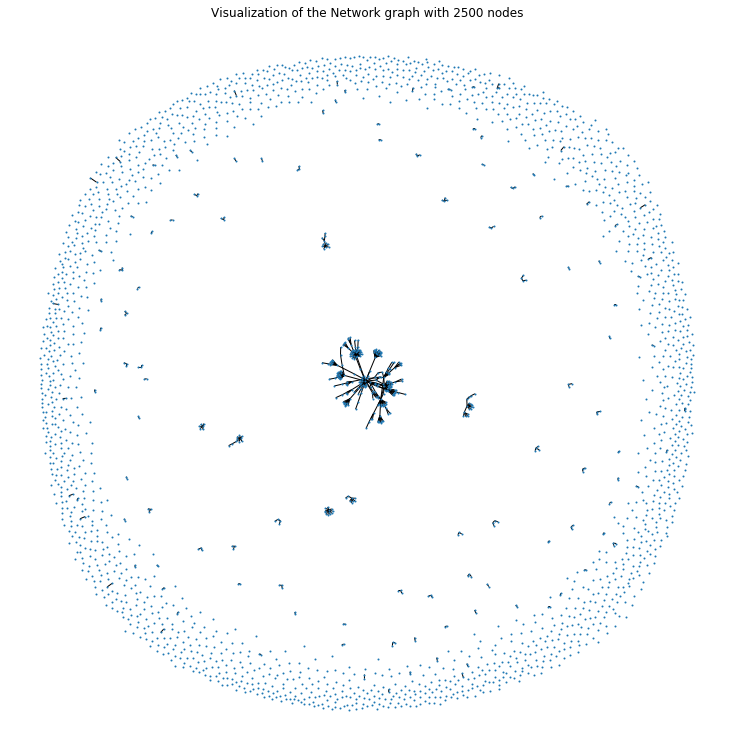

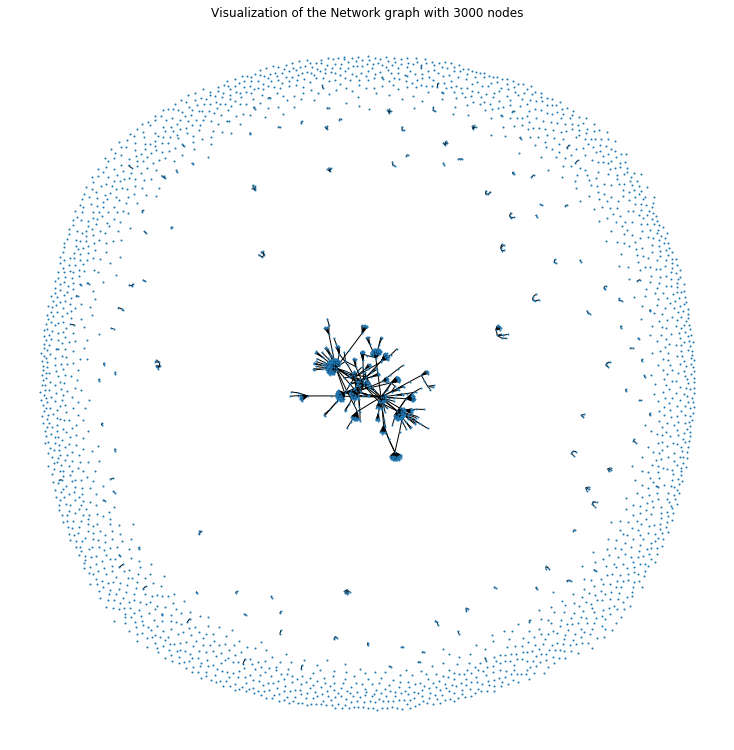

In [5]:
visualize_graph(graphNetwork1)

We can clearly see the evolution of the aggregation of the nodes of the graph. At the beginning only small components are formed. From a certain range, a priori between 2000 and 2500 nodes, a giant component begins to form (because the average degree of the nodes begins to become quite important).

Question 2

In [6]:
nbEdges = graphNetwork1.number_of_edges()
print(f"Network1 contains {nbEdges} edges")

nbNodes = graphNetwork1.number_of_nodes()
print(f"Network1 contains {nbNodes} nodes")

Network1 contains 18584 edges
Network1 contains 13033 nodes


#### Exercise 2.2:  Node degree distribution

Question 1

The best way to represent the distribution of the degree of the nodes is using the log-log cumulative plot, since the representation will then be done without "jumps" as is the case for the log-log distribution plot.

Question 2

In [7]:
degrees = pd.DataFrame(graphNetwork1.degree(), columns=["node", "degree"])

degrees.head(10)

,node,degree
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,3
6,6,2
7,7,1
8,8,1
9,9,2


In [8]:
def nbNodeAboveDegree(x, graphNetwork):
    
    """
    This function calculates the proportion of nodes of degree > x for a network.
    
    We can approximate the proportion by the distribution, according to the law of large numbers, because our number of nodes is large according to question 1.
    """
    degrees = pd.DataFrame(graphNetwork.degree()).rename(columns={0: "node", 1: "degree"})
    if len(degrees[degrees.degree>x]):
        return len(degrees[degrees.degree>x])/len(degrees)



In [9]:
def log_cumulative_plot(graphNetwork, threshold, plot=False, data_plot=False):
    
    degrees = graphNetwork.degree()
    maxDegree = max([value[1] for value in list(degrees)])

    X = pd.Series(np.arange(1, maxDegree))

    X_plot = np.log(X)
    indexes = X_plot<=threshold 
    X_plot = X_plot[indexes]
    
    Y = []  
    for ele in X[indexes]:
        Y.append(nbNodeAboveDegree(ele, graphNetwork))
        
    Y_plot = np.log(Y)

    plt.plot(X_plot, Y_plot)
    plt.xlabel("Log of degree")
    plt.ylabel("Log of the percentage of nodes with degree > x")
    plt.title("Log-log cumulative plot of the node distribution")

    if plot:
        plt.show()
        
    if data_plot:
        return X_plot, Y_plot


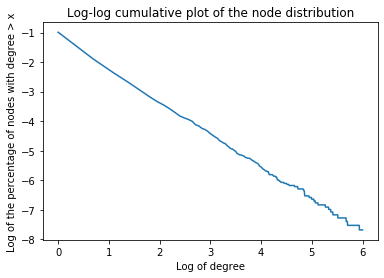

In [10]:
log_cumulative_plot(graphNetwork1, 6, plot=True) # We reduce X_plot, because the distribution becomes very staircase after 6.

In [11]:
def linear_regression(graphNetwork):

    X_plot, Y_plot = log_cumulative_plot(graphNetwork, 6, plot=False, data_plot=True) 

    #find line of best fit
    a, b = np.polyfit(X_plot, Y_plot, 1)

    #add points to plot
    plt.scatter(X_plot, Y_plot)

    #add line of best fit to plot
    plt.plot(X_plot, a*X_plot+b, linestyle='--', color='red')   
    plt.xlabel("Log of degree")
    plt.ylabel("Log of the percentage of nodes with degree > x")
    plt.title("Log-log cumulative plot of the node distribution - With linear regression",  y=1.2)

    plt.show()

    Y_pred = a*X_plot + b
    r_squared = r2_score(Y_plot, Y_pred)

    print(f"Leading coefficient : {a}")
    print(f"Originally ordered : {b}")
    print(f"coefficient of determination : {r_squared}")

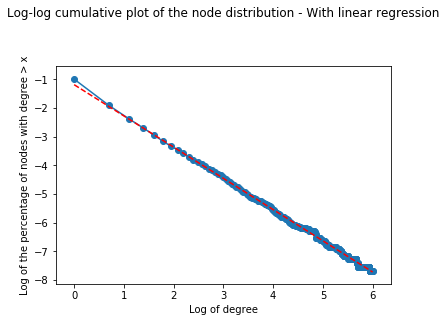

Leading coefficient : -1.0893944033554672
Originally ordered : -1.1836439945127033
coefficient of determination : 0.9973947779447621


In [12]:
linear_regression(graphNetwork1)

The coefficient of determination is > 0.99, therefore we can reasonably consider that it is a straight line.

log(Y) = a*log(X) + b  => Y = exp(b) * X^a

So the distribution of degrees follows a power law. 

This was not represented graphically because it is not important for the regression, but for x=0, the value of the cumulative distribution is 1 (so the log is 0), because all the nodes in the graph are at least of degree 1.

Question 3


Using question 2, we see that P(degree > x) is constant (especially when x is negative) up to a certain value that we will call β. 
And for x >= β, we have a linear relationship for the log-log plot, which is equivalent to a power relationship. 

Thus, it seems that the distribution of degrees follows a Pareto law with parameters (β, γ).

Now that we know that the degree distribution follows a power law, we might as well do a fit with a power law.

Parameters : Y = a * X^(-b) = β^γ * X^(-γ)

=> (β, γ) = (a^(1/γ), b)

In [13]:
def power_law(x, a, b):
    return a * np.power(x, -b)

def power_law_fit(graphNetwork):
    
    degrees = graphNetwork.degree()
    maxDegree = max([value[1] for value in list(degrees)])

    X = pd.Series(np.arange(1, maxDegree))
    
    Y = []
    for ele in X:
        Y.append(nbNodeAboveDegree(ele, graphNetwork))
        
    popt, pcov = curve_fit(power_law, X, Y)


    plt.plot(X, Y, 'b-', label='data')
    plt.plot(X, power_law(X, *popt), 'r--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    plt.xlabel('Degree')
    plt.ylabel('Percentage of Nodes Above Degree')
    plt.legend()
    plt.show()

    a,b = popt

    gamma = b
    beta = a**(1/gamma)

    print("The degree distribution follows a Pareto distribution with parameters :")
    print(f" γ = {gamma}")
    print(f" β = {beta}")

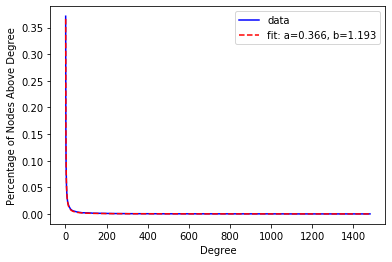

The degree distribution follows a Pareto distribution with parameters :
 γ = 1.192804016644055
 β = 0.4309892966485748


In [14]:
power_law_fit(graphNetwork1)

#### Exercise 2.3: Giant component

Question 1

In [14]:

# This function was coded to look through the graph 
# and find the number of connected components, before realizing that the function already existed with networkx...

""""
import sys

sys.setrecursionlimit(10000000)  

def parcours(indice, visited_indices):
    global tab, nb, sizes
    
    if indice in tab.index and indice not in visited_indices:
        visited_indices.add(indice)
        a = tab.loc[indice, 'fromNodeId']
        b = tab.loc[indice, 'toNodeId']
        
        # Delete the line corresponding to the index
        tab = tab.drop(indice)
        
        # Find the indices of the lines to delete
        a_indices_from = tab[tab['fromNodeId'] == a].index.tolist()
        b_indices_from = tab[tab['fromNodeId'] == b].index.tolist()
        a_indices_to = tab[tab['toNodeId'] == a].index.tolist()
        b_indices_to = tab[tab['toNodeId'] == b].index.tolist()
        
        indices_to_drop = set(a_indices_from + b_indices_from + a_indices_to + b_indices_to)
        
        # Browse new clues to delete
        for new_indice in indices_to_drop:
            parcours(new_indice, visited_indices)
        
        
      


tab = network1.copy() 
visited_indices = set()
nb = 0
sizes = []
tmp = 0

while not tab.empty:
    tmp = len(visited_indices)
    parcours(tab.index[0], visited_indices)
    nb += 1
    size = len(visited_indices) - tmp
    sizes.append(size)

print(nb)
print(sizes)

"""

'"\nimport sys\n\nsys.setrecursionlimit(10000000)  \n\ndef parcours(indice, visited_indices):\n    global tab, nb, sizes\n    \n    if indice in tab.index and indice not in visited_indices:\n        visited_indices.add(indice)\n        a = tab.loc[indice, \'fromNodeId\']\n        b = tab.loc[indice, \'toNodeId\']\n        \n        # Delete the line corresponding to the index\n        tab = tab.drop(indice)\n        \n        # Find the indices of the lines to delete\n        a_indices_from = tab[tab[\'fromNodeId\'] == a].index.tolist()\n        b_indices_from = tab[tab[\'fromNodeId\'] == b].index.tolist()\n        a_indices_to = tab[tab[\'toNodeId\'] == a].index.tolist()\n        b_indices_to = tab[tab[\'toNodeId\'] == b].index.tolist()\n        \n        indices_to_drop = set(a_indices_from + b_indices_from + a_indices_to + b_indices_to)\n        \n        # Browse new clues to delete\n        for new_indice in indices_to_drop:\n            parcours(new_indice, visited_indices)\n    

In [15]:
number_of_connected_components = len([ele for ele in  nx.connected_components(graphNetwork1)])


print(f"Network1 has {number_of_connected_components} connected components")



Network1 has 192 connected components


Question 2

The course says that a giant component is a connected component that is:

▪ (a) much larger than other
connected components

▪ (b) significant fraction of whole
network

Let's check it here.

In [16]:
connected_components = [ele for ele in  nx.connected_components(graphNetwork1)]

#connected_components is sorted by decreasing component size
biggest_connected_component_len = len(connected_components[0])
second_biggest_connected_component_len = len(connected_components[1])

print(f"The giant component is approximately {biggest_connected_component_len//second_biggest_connected_component_len}  times larger than the second largest component. \n")
print("We can therefore consider that condition (a) is verified.")


The giant component is approximately 1796  times larger than the second largest component. 

We can therefore consider that condition (a) is verified.


In [17]:
percentage_of_network = int((biggest_connected_component_len/nbNodes) * 100)

print(f"The giant component comprises approximately {percentage_of_network} percent of the network node total. \n")
print("We can therefore consider that condition (b) is verified.")


The giant component comprises approximately 96 percent of the network node total. 

We can therefore consider that condition (b) is verified.


In [18]:
print(f"So Network1 has a giant component comprising {biggest_connected_component_len} nodes.")

So Network1 has a giant component comprising 12576 nodes.


#### Exercise 2.4: Short paths & Small-worlds

In [19]:
def visualization_length_paths(node, graphNetwork):
    
    """
    This function creates a dictionary with the path sizes as keys and the number of each of these paths as values.
    """
    lengths = {}
    
    for length in nx.single_source_shortest_path_length(graphNetwork, node).values():
        if length in lengths:
            lengths[length] += 1
        else:
            lengths[length] = 1
    return lengths

def number_nodes_reachable_from(node, r, graphNetwork):
    
    """
    Thanks to the visualization_length_paths function, this function determines 
    the total number of paths accessible up to a distance r from a certain node.
    """
    
    lengths = visualization_length_paths(node, graphNetwork)
    nb_nodes_reachable = 0
    
    for (len_path, nb_node) in lengths.items():
        if len_path > r:
            break
        nb_nodes_reachable += nb_node
        
    return nb_nodes_reachable
    
def on_button_clicked(graphNetwork, size_for_average):
    
    """
    This fonction compute the number of node pairs at a given distance - on average for 100 nodes first, 
    and then the percentage of the network accessible at a distance <= r - on average for 100 nodes."
    """
    
    nodes = np.random.choice(graphNetwork.nodes(), size=size_for_average, replace=False) 
    lengths = {}
    n_nodes = len(nodes)
    
    for node in nodes:
        lengths_node = visualization_length_paths(node, graphNetwork)
        for length, value in lengths_node.items():
            if length in lengths:
                lengths[length] += value
            else:
                lengths[length] = value
    lengths = {length : np.floor(value/n_nodes) for length, value in lengths.items()}
    
    plt.figure(figsize=(10, 6))

    X = lengths.keys()
    Y = lengths.values()
    
    plt.subplot(1, 2, 1)
    plt.xlabel("Size of the shortest path between two nodes")
    plt.ylabel("Number of node pairs")
    plt.gca().get_xaxis().set_major_locator(plt.MaxNLocator(integer=True)) #integer in axis
    plt.title("Number of node pairs at a given distance")
    plt.bar(X, Y)

    
    max_r = len(X)
    number_nodes_reachable = np.zeros(shape = max_r)
    for node in nodes:
        for r in X:
             number_nodes_reachable[r] += number_nodes_reachable_from(node, r, graphNetwork)
    
    number_nodes_reachable = np.floor(number_nodes_reachable/n_nodes)
    max_reachable = max(number_nodes_reachable)
    number_nodes_reachable = number_nodes_reachable/max_reachable
    
    plt.subplot(1, 2, 2)
    plt.xlabel("Maximum path size between two nodes")
    plt.ylabel("Percentage of network accessible")
    plt.gca().get_xaxis().set_major_locator(plt.MaxNLocator(integer=True)) #integer in axis
    plt.title("Percentage of the network accessible at a distance <= r")
    plt.bar(X, number_nodes_reachable)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=1)
    
    plt.show()

    




Button(description='Choose 100 random nodes in the graph:', layout=Layout(width='500px'), style=ButtonStyle())

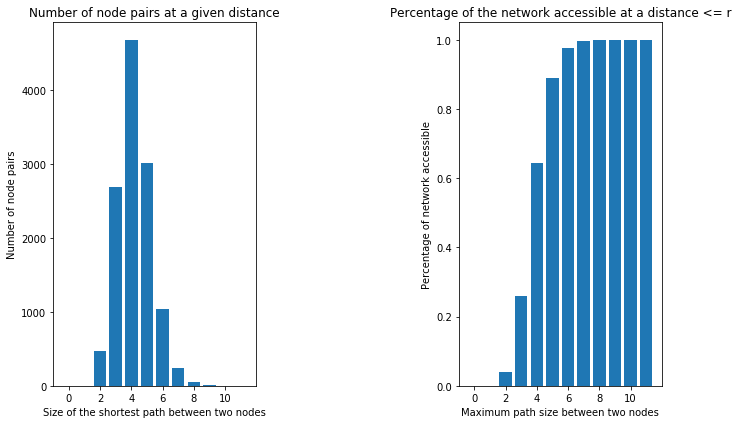

In [20]:
button = widgets.Button(description=f"Choose 100 random nodes in the graph:")
button.on_click(lambda _: on_button_clicked(graphNetwork1, size_for_average=100))
button_width = "500px"
button.layout.width = button_width
display(button)

By averaging over 100 nodes, we see that we reach the entire network very quickly when the length of the path increases from unit to unit. 

And what's more, it seems that the average length between two nodes in the network is around 4 nodes.

So we can consider that network1 is a small world.

#### Exercise 2.5: Network comparison

Question 1

In [21]:
path = "../data/network2.csv"
nameOfColumns = ["fromNodeId", "toNodeId"]


network2 = pd.read_csv(path, names=nameOfColumns, skiprows=2, sep=",")
network2.head(10)

,fromNodeId,toNodeId
0,135627,135630
1,135627,135623
2,135627,135625
3,135627,135626
4,137038,137040
5,137038,137036
6,137038,137045
7,137038,137037
8,197625,197623
9,197625,197628


In [22]:
"""
After loading the csv into a dataframe, 
we create the structure of the undirected graph
"""

graphNetwork2 = nx.Graph()
graphNetwork2.add_nodes_from(network2["fromNodeId"])
graphNetwork2.add_nodes_from(network2["toNodeId"])

edges = [(i, j) for i,j in zip(network2["fromNodeId"], network2["toNodeId"])]
graphNetwork2.add_edges_from(edges)




Button(description='Network graph every 5000 node', layout=Layout(width='500px'), style=ButtonStyle())

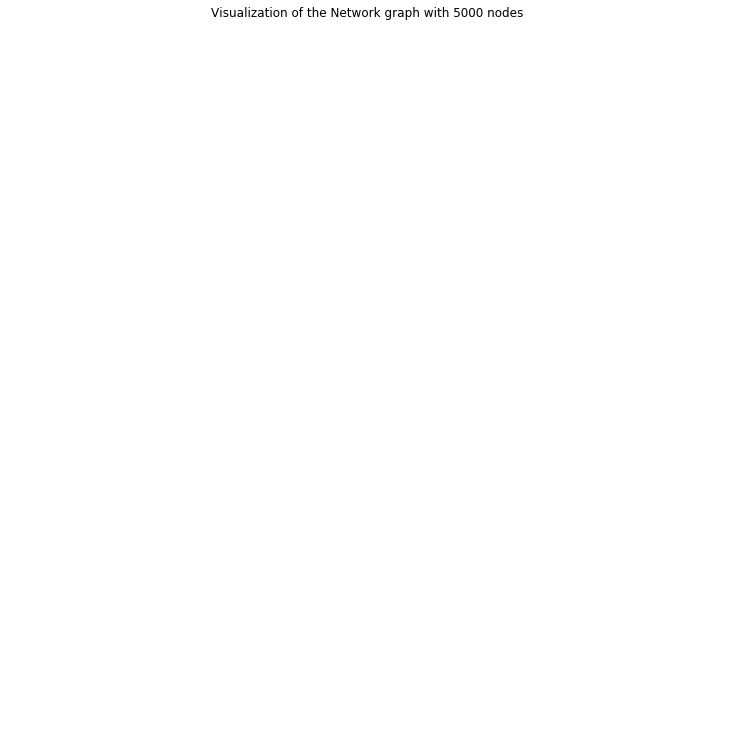

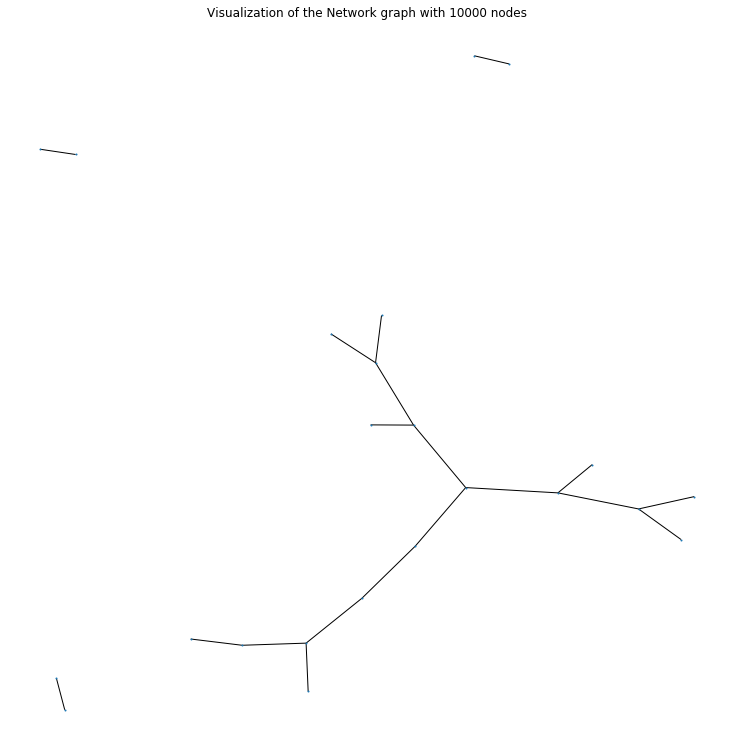

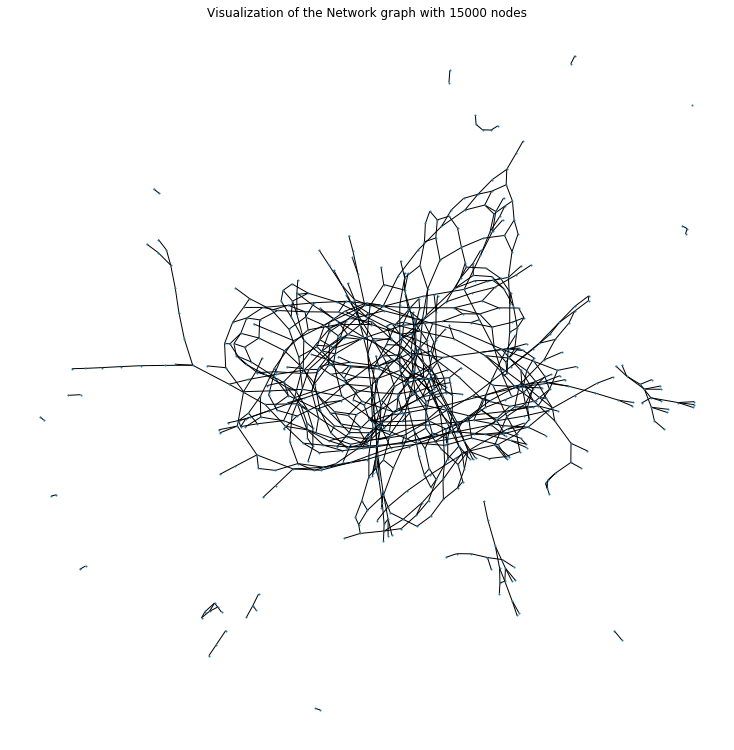

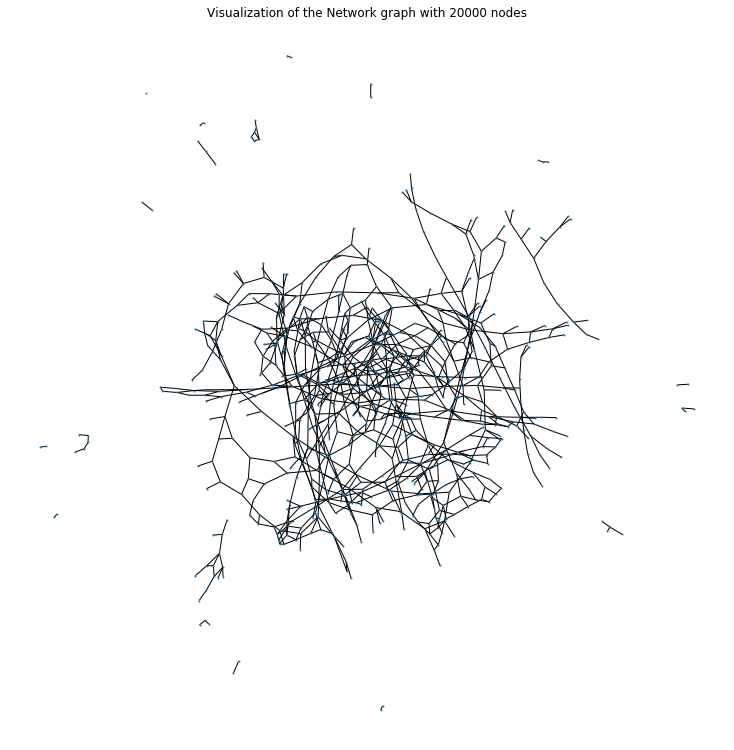

In [23]:
visualize_graph(graphNetwork2, 5000, 20001)

The network2 does not start at node 0 and does not contain all nodes as an interval of integers like the previous graph. As a result it appears messier and adjustments to previous functions have been made to allow it to display.

In [24]:
nbEdges2 = graphNetwork2.number_of_edges()
print(f"Network2 contains {nbEdges2} edges")

nbNodes2 = graphNetwork2.number_of_nodes()
print(f"Network2 contains {nbNodes2} nodes")

Network2 contains 43516 edges
Network2 contains 26542 nodes


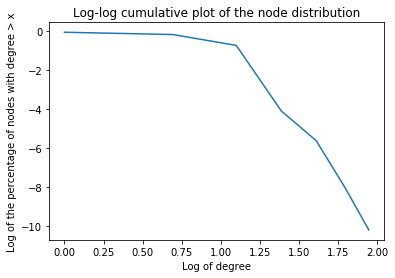

In [25]:
log_cumulative_plot(graphNetwork2, 6, plot=True)

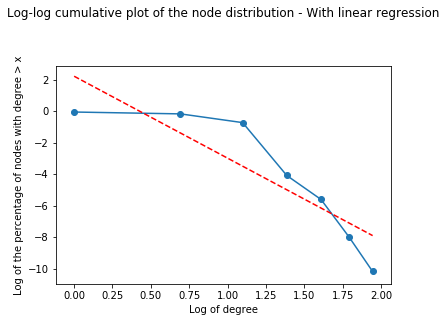

Leading coefficient : -5.200182177654649
Originally ordered : 2.2117247776676914
coefficient of determination : 0.7805441429737608


In [26]:
linear_regression(graphNetwork2)

The R^2 is low, and we clearly see that the log-log plot does not give a straight line unlike network1.

In [27]:
def polynomial_fit(x, *coefficients):
    return sum(c * x**i for i, c in enumerate(coefficients))


def polynomial_fit_and_plot(graphNetwork, degree):
    X, Y = log_cumulative_plot(graphNetwork, 6, plot=False, data_plot=True)      

    # Initialize polynomial parameters
    initial_guess = [0] * (degree + 1)  # Initialization to zero for all coefficients
    popt, pcov = curve_fit(polynomial_fit, X, Y, p0=initial_guess)

    plt.plot(X, Y, "b-", label="Data")
    plt.plot(X, polynomial_fit(X, *popt), 'r--', label="Fit")
    plt.xlabel("Log of degree")
    plt.ylabel("Log of the percentage of nodes with degree > x")
    plt.title("Log-log cumulative plot of the node distribution - With polynomial regression",  y=1.2)


    print("The coefficients of the fitted polynomial are:", popt)



The coefficients of the fitted polynomial are: [-6.04127160e-02 -3.30532770e+02  1.32267037e+03 -2.01864730e+03
  1.48255037e+03 -5.28889023e+02  7.36408731e+01]


/opt/anaconda-2020-02/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


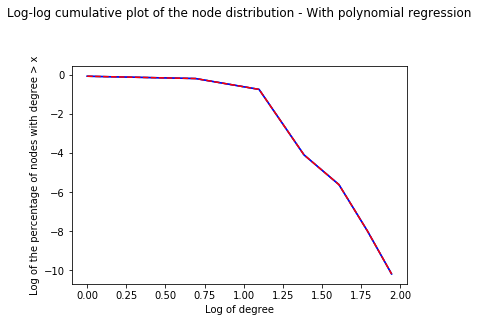

In [28]:
polynomial_fit_and_plot(graphNetwork2, 6)  #Fit with a polynomial of degree 6

Thus the log-log plot admits a polynomial fit of degree 6, and the degree distribution of network2 does not seem to follow a known probability law.

In [29]:
number_of_connected_components = len([ele for ele in  nx.connected_components(graphNetwork2)])


print(f"Network2 has {number_of_connected_components} connected components.")



Network2 has 5 connected components.


In [30]:
connected_components2 = [ele for ele in  nx.connected_components(graphNetwork2)]

#connected_components is sorted by decreasing component size
biggest_connected_component_len2 = len(connected_components2[0])
second_biggest_connected_component_len2 = len(connected_components2[1])

print(f"The giant component is approximately {biggest_connected_component_len2//second_biggest_connected_component_len2}  times larger than the second largest component. \n")
print("We can therefore consider that condition (a) is verified.")


The giant component is approximately 1103  times larger than the second largest component. 

We can therefore consider that condition (a) is verified.


In [31]:
percentage_of_network2 = int((biggest_connected_component_len2/nbNodes2) * 100)

print(f"The giant component comprises approximately {percentage_of_network2} percent of the network node total. \n")
print("We can therefore consider that condition (b) is verified.")


The giant component comprises approximately 99 percent of the network node total. 

We can therefore consider that condition (b) is verified.


In [32]:
print(f"So Network2 has a giant component comprising {biggest_connected_component_len2} nodes.")

So Network2 has a giant component comprising 26481 nodes.


Button(description='Choose 5 random nodes in the graph:', layout=Layout(width='500px'), style=ButtonStyle())

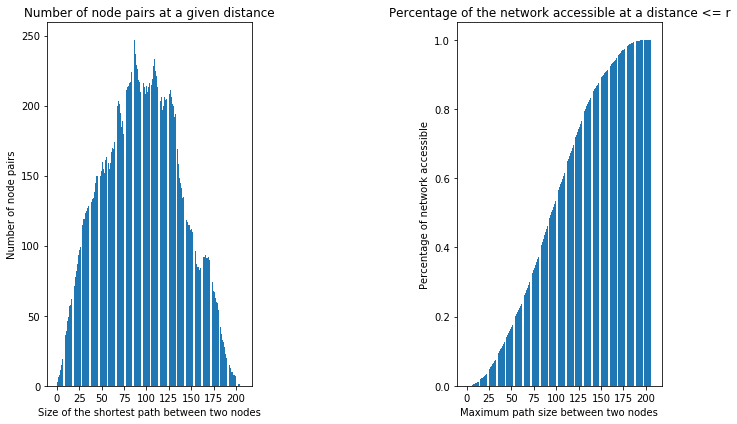

In [33]:
button = widgets.Button(description="Choose 5 random nodes in the graph:")
button.on_click(lambda _: on_button_clicked(graphNetwork2,  size_for_average=5))
button_width = "500px"
button.layout.width = button_width
display(button)


        



The histograms are hashed due to the disparity in network2 values, as mentioned above.

We notice this time that on average, it takes around a hundred steps to connect any two nodes in the graph, and the variation in the percentage of nodes reachable as a function of distance seems to only vary significantly every 25 nodes.

It is therefore clear that Network2 is not a small world.

Question 2

In [34]:
print(f"Network2 is {round(nbNodes2/nbNodes, 2)} times larger than network1.")
print(f"Network2 contains {round(nbEdges2/nbEdges, 2)} times more edges than network1.")


Network2 is 2.04 times larger than network1.
Network2 contains 2.34 times more edges than network1.


In addition to the size difference, network 2 differs from network1 in several aspects:

- Its nodes do not span a range of integer values, but there are sometimes significant gaps between the values. Network2 is thus much more dispersed than network1, in addition to being twice as large.

- Network2 is not a small world, and it takes a path 25 times longer than for network1 on average to be able to reach the same proportion of the network.

- Network2 has a degree distribution which does not follow a known probability law unlike network1.

#### Exercise 2.6: Network identification

Network1 : network of roads around the city of New-York

Network2 : subgraph of routers comprising the Internet 



Justification : 
    

Giant component : In the network of roads around New York, we expect there to be a giant component, as most intersections are connected by roads. In an Internet router subgraph, the giant component is also expected, because most routers are interconnected. 
So the giant component does not allow us to choose between the networks.

Compactness : The road network around New York can be considered more compact because it is based on the physical geography of the city. The Internet router subgraph might be less compact due to the way routers are dispersed around the world and interconnected via long-distance physical links.

Thus network 2 is more likely to represent the subgraph of routers comprising the Internet, since it is more extensive than network1 and is not a small world; it is therefore less compact.

